In [1]:
import pickle
import sys
import numpy as np
import pandas as pd
import re
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing


from sklearn.feature_extraction.text import CountVectorizer

In [2]:
sys.path.append('/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src')

In [3]:
import imp
import tokenizer
import w2v_preprocessing
imp.reload(w2v_preprocessing)

<module 'w2v_preprocessing' from '/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src/w2v_preprocessing.py'>

Что можно сделать по word2vec:
1. Разобраться, что делать с незнакомыми словами
2. Выбрать частоту отсечения для словаря
3. Разбить текст на предложения (каждому сопоставить источник и метку тональности)
4. Учесть смайлики.

In [8]:
#df = pd.read_csv('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv')
df = pd.read_csv('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv', 
                dtype={'text':str, 'score':np.int16, 'source':str})
df.dropna(inplace=True, subset=['text'])

In [ ]:
tok = tokenizer.AgressiveMicroblogTokenizer()

In [ ]:
tok.tokenize(df.loc[0, 'text'])[2].kind is tokenizer.Kind.word

In [ ]:
print(tok.tokenize(df.loc[0, 'text'])[2].stem)

In [ ]:
tok.tokenize(df.loc[0, 'text'])[3]

In [27]:
text = (
    "югославию Россия америке бразилии Ну, давай-ка\n разберем по частям тобою написанное))))!"
    " Складывается впечатление\n, что ты реально контуженный,"
    " обиженный жизнью имбецил. Могу тебе и в глаза сказать, "
    "готов приехать послушать послушать 9999?")

preprocessor = w2v_preprocessing.Lemmatizer()
tokens = preprocessor.process(text)
print(tokens)

['югославия', 'россия', 'америка', 'бразилия', 'давать', 'ка', 'разбирать', 'часть', 'написать', 'складываться', 'впечатление', 'реально', 'контузить', 'обиженный', 'жизнь', 'имбецил', 'мочь', 'глаз', 'сказать', 'готовый', 'приезжать', 'послушать', 'послушать']


In [ ]:
pool = multiprocessing.Pool()

In [7]:
preprocessor = w2v_preprocessing.Lemmatizer()
#pool = multiprocessing.Pool(processes=4)
all_tokens = []
for text in tqdm_notebook(df.text.values):
    try:
        tokens = preprocessor.process(text)
        all_tokens.append(tokens)
    except:
        print(text)
#tokens = pool.map(preprocessor.process, df.text.values)

HBox(children=(IntProgress(value=0, max=92236), HTML(value='')))

In [8]:
len(all_tokens)

92236

In [9]:
len(preprocessor.cache)

248831

In [5]:

#from transformer import TopFrequentWordsIndexer
import transformer
imp.reload(transformer)

<module 'transformer' from '/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src/transformer.py'>

In [9]:
lemmatizer = w2v_preprocessing.Lemmatizer()

model = transformer.TopFrequentWordsIndexer(vocabulary_size=50000, lemmatizer=lemmatizer)

In [10]:
%%time
model.fit(df.text.values)


 43%|████▎     | 39478/92236 [00:00<00:00, 392109.47it/s]

Converting to lowercase...



  0%|          | 0/92236 [00:00<?, ?it/s]

lemmatizing



 29%|██▉       | 26751/92236 [00:33<01:22, 790.93it/s]


 43%|████▎     | 39987/92236 [01:08<01:29, 583.54it/s]


 54%|█████▍    | 49817/92236 [01:43<01:28, 481.69it/s]


 66%|██████▌   | 60816/92236 [02:16<01:10, 445.51it/s]


 79%|███████▉  | 73136/92236 [02:50<00:44, 429.38it/s]


 87%|████████▋ | 80498/92236 [03:24<00:29, 394.10it/s]


100%|██████████| 92236/92236 [00:01<00:00, 54214.35it/s]

CPU times: user 3min 29s, sys: 10.3 s, total: 3min 40s
Wall time: 3min 57s


In [12]:
%%time
X_idx = model.transform(df.text.values)


 35%|███▌      | 32307/92236 [00:00<00:00, 321328.94it/s]

Converting to lowercase...



  0%|          | 255/92236 [00:00<00:36, 2532.93it/s]

lemmatizing



 33%|███▎      | 30400/92236 [00:34<01:09, 885.07it/s]


 50%|████▉     | 46042/92236 [01:10<01:10, 657.52it/s]


 59%|█████▊    | 54053/92236 [01:44<01:13, 519.41it/s]


 73%|███████▎  | 67321/92236 [02:17<00:50, 489.44it/s]


 83%|████████▎ | 76309/92236 [02:51<00:35, 444.49it/s]


 96%|█████████▌| 88588/92236 [03:27<00:08, 427.15it/s]


100%|██████████| 92236/92236 [00:01<00:00, 59222.45it/s]

CPU times: user 3min 24s, sys: 9.1 s, total: 3min 33s
Wall time: 3min 36s


In [11]:
import pickle
with open('model_tokenize.pkl', 'wb') as f:
    pickle.dump(model, f)

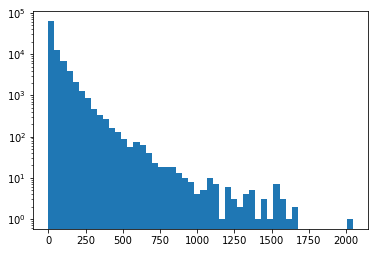

In [37]:
lengths = [len(x) for x in X_idx]
_ = plt.hist(lengths, bins=50)
plt.gca().set_yscale('log')

Разобьем текст на предложения

In [18]:
sentences = []
regex = re.compile('\. |\? |\! ')
for text in tqdm_notebook(df.text.values):
    s = regex.split(text)
    if s:
        sentences.extend(s)
    else:
        sentences.append(text)

HBox(children=(IntProgress(value=0, max=92236), HTML(value='')))

In [25]:
%%time
X_idx = model.transform(sentences)


 17%|█▋        | 75957/456631 [00:00<00:00, 754539.03it/s]

Converting to lowercase...



  0%|          | 351/456631 [00:00<02:10, 3490.60it/s]

lemmatizing



 17%|█▋        | 76205/456631 [00:29<02:24, 2624.36it/s]


 30%|███       | 137145/456631 [00:57<02:14, 2379.43it/s]


 41%|████      | 187660/456631 [01:26<02:04, 2164.41it/s]


 52%|█████▏    | 239434/456631 [01:55<01:44, 2078.27it/s]


 64%|██████▍   | 291349/456631 [02:23<01:21, 2027.15it/s]


 75%|███████▍  | 340583/456631 [02:52<00:58, 1972.97it/s]


 86%|████████▌ | 390481/456631 [03:21<00:34, 1939.30it/s]


 97%|█████████▋| 443541/456631 [03:50<00:06, 1924.35it/s]


100%|██████████| 456631/456631 [00:02<00:00, 187306.44it/s]

CPU times: user 3min 48s, sys: 11.8 s, total: 4min
Wall time: 3min 59s


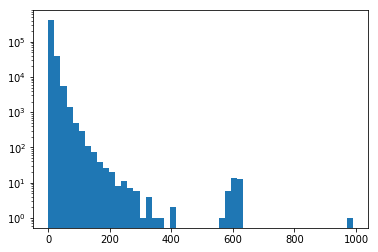

In [26]:
lengths = [len(x) for x in X_idx]
_ = plt.hist(lengths, bins=50)
plt.gca().set_yscale('log')

In [24]:
sentences[3]

'free wi-fi "tattelecom_unlim" :) good while waiting..so pretty interior though'

In [22]:
df.text.values[:20]

array(['2 рабочих места, выделенное рабочее место по кредитам, 1 касса. pos-терминал, сенсорный экран для управления "сбербанк онл@йн", банкомат на улице возле входа. очереди имеются.',
       'free wi-fi "tattelecom_unlim" :) good while waiting..so pretty interior though',
       'аппарат по выдачи талонов сломан!вспоминаем старую,"добрую" очередь,как в поликлиниках)',
       'в сбербанке установили новую программу-теперь квитанции петроэлектросбыта не принимают.класс.в сбере,как обычно,"приятные ноу-хау"...)',
       'в электронной очереди реально дождаться обслуживания только выбрав "платежи"',
       'владельцы виза и мастеркард голд, добро пожаловать в кабинет "сбербанк премьер"! тут бесплатный вайфай даже есть.',
       'говоришь им "добрый день", а в ответ тишина! пора учить своих сотрудников здороваться! :)',
       'если хотите послушать "луч солнца золотого" и "есть только миг", непременно зайдите!!!)',
       'задавать вопросы по "пластику" лучше здесь не задавать... какие-т

In [ ]:
df.source.value_counts()

In [ ]:
df.score.value_counts()

In [ ]:
CV = CountVectorizer(ngram_range=(3, 3))
cnt = CV.fit_transform(df.text.values)

In [12]:
%%time
CV_words = CountVectorizer(ngram_range=(1, 1), min_df=20)
cnt = CV_words.fit_transform(df.text.values)

CPU times: user 6 s, sys: 395 ms, total: 6.4 s
Wall time: 6.43 s


Построим зависимость размера словаря от min_df

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

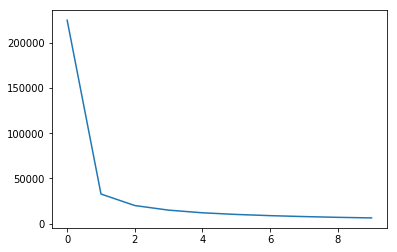

In [13]:
lengths = []
min_dfs = np.arange(0, 100, 10).astype('int32')
for min_df in tqdm_notebook(min_dfs):
    CV_words = CountVectorizer(ngram_range=(1, 1), min_df=min_df)
    cnt = CV_words.fit_transform(df.text.values)
    vocab = [k for k in sorted(CV_words.vocabulary_.keys(), key=lambda x: CV_words.vocabulary_[x])]
    lengths.append(len(vocab))
plt.plot(lengths)

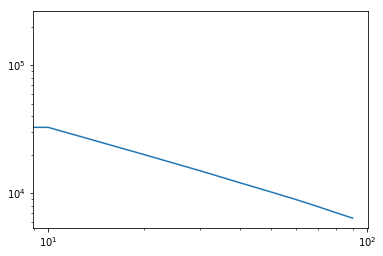

In [14]:
plt.plot(min_dfs, lengths)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

Выгрузка словаря. Слова размещаем в порядке появления

In [ ]:
vocab = [k for k in sorted(CV_words.vocabulary_.keys(), key=lambda x: CV_words.vocabulary_[x])]

In [ ]:
len(vocab), len(df)

In [ ]:
len(CV_words.vocabulary_)

In [ ]:
df.head()

In [ ]:
df.score.value_counts(dropna=False)

In [ ]:
df.source.value_counts(dropna=False)

In [ ]:
df.text.value_counts(dropna=False)

In [ ]:
for c in df.columns.values:
    print(df[c].dtype)

In [ ]:
f = open('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv', 'r')
texts = []
scores = []
sources = []
lines = f.readlines()[1:]
for line in tqdm_notebook(lines):
    try:
        first = 0
        last = 0
        for i, s in enumerate(line):
            if s == '"':
                first = i + 1
                break
        for i, s in enumerate(reversed(line)):
            if s == '"':
                last = len(line) - i - 1
                break
        if (first == 0) and (last == 0):
            parts = line.split(',')
            sources.append(parts[-1].replace('\n', ''))
            scores.append(float(parts[-2]))
            texts.append(''.join(parts[:-2]))
        else:
            texts.append(line[first:last])
            parts = line[last + 2:-1].split(',')
            #print(parts)
            n = len(parts)
            if n == 2:
                sources.append(parts[-1].replace('\n', ''))
                scores.append(float(parts[-2]))
            elif n == 1:
                try:
                    scores.append(float(parts[-1]))
                except ValueError:
                    print(line)
                sources.append(None)
            else:
                scores.append(None)
                sources.append(None)
                #print(line)
    except AssertionError:
        print(line)
        print("-"*20)
assert len(texts) == len(scores), 'разное число текстов и оценок'
assert len(texts) == len(sources), 'разное число текстов и источников'

In [ ]:
with open('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv', 'r') as myfile:
    data=myfile.read().replace('\n', '')

Разделение файла на части. Разбиваем оценками (предполагается, что она есть у каждого сообщения)

In [ ]:
#delim = '(,\d\.0,|,\d,)'
delim = ',\d\.0,'
parts = re.split(delim, data)

In [ ]:
parts[:20]

In [ ]:
lengths = [len(x) for x in parts]
plt.plot(lengths[:-142], 'k*', alpha=0.5)

In [ ]:
_ = plt.hist(lengths[:-142], bins=91)

In [ ]:
max(lengths[:-142]) / 23

Сохраняем оценки

In [ ]:
scores = parts[1::2]
len(scores)

In [ ]:
scores[-1]

Преобразуем оценки в числа

In [ ]:
scores = [float(x.replace(',', '')) for x in scores]

In [ ]:
sources = []
texts = []
st = parts[0::2].copy()
for i, s in enumerate(st):
    if s.startswith('foursquare'):
        sources.append('foursquare')
        st[i] = st[i].replace('foursquare', '')
    else:
        sources.append(None)

In [ ]:
st[0] = st[0].replace('text,score,source"', '')

In [ ]:
data = pd.DataFrame({'text':st, 'score':scores, 'source':sources})

In [ ]:
len(st), len(scores), len(sources)

In [ ]:
st[-1], st[-2]

In [ ]:
data = pd.read_csv('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv',
                  encoding='cp1251', delimiter='"')

In [ ]:
sys.path.insert(0, '/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src/')

In [ ]:
import transformer

In [ ]:
path = '/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/models/word2vec_standard_neutral.bin'
with open(path, 'rb') as model_fd:
    w2v = pickle.load(model_fd)

In [ ]:
dir(w2v)

In [ ]:
w2v.steps

In [ ]:
w2v.inverse_transform

In [ ]:
import tensorflow as tf

In [ ]:
import keras

In [ ]:
data = pd.read_csv('/Users/ak/Yandex.Disk.localized/Магистратура ВШЭ/Chat_word_autofill/Личные почты для Azure - Sheet1.csv')
data = data[~data['Студент'].isin(['Колпаков Егор', 'Коннов Артем'])]
data.head(30)

In [ ]:
groupmates = data['Студент'].values
#np.random.seed(100500)
np.random.choice(groupmates, size=5, replace=False)